In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pylab as plt
import matplotlib.pyplot as pyplt
from matplotlib import gridspec

import sklearn
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectPercentile, chi2

import cmath
import random

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import svm
import scipy as sp
import scipy.fftpack

import lib
import library

# Генерация данных

In [2]:
dataset = library.creat_dataset()
dataset.head()

[INFO] -- Selected sensor data types: ['attitude', 'userAcceleration']
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog', 'std', 'sit']
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(1412865, 13)


,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id,weight,height,age,gender,trial
0,1.528132,-0.733896,0.696372,0.294894,-0.184493,0.377542,0.0,0.0,102.0,188.0,46.0,1.0,1.0
1,1.527992,-0.716987,0.677762,0.219405,0.035846,0.114866,0.0,0.0,102.0,188.0,46.0,1.0,1.0
2,1.527765,-0.706999,0.670951,0.010714,0.134701,-0.167808,0.0,0.0,102.0,188.0,46.0,1.0,1.0
3,1.516768,-0.704678,0.675735,-0.008389,0.136788,0.094958,0.0,0.0,102.0,188.0,46.0,1.0,1.0
4,1.493941,-0.703918,0.672994,0.199441,0.353996,-0.044299,0.0,0.0,102.0,188.0,46.0,1.0,1.0


/home/apxapa/Документы/GitHub/2020_Project8/code/library.py:144: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig('../data/data.png')
/home/apxapa/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


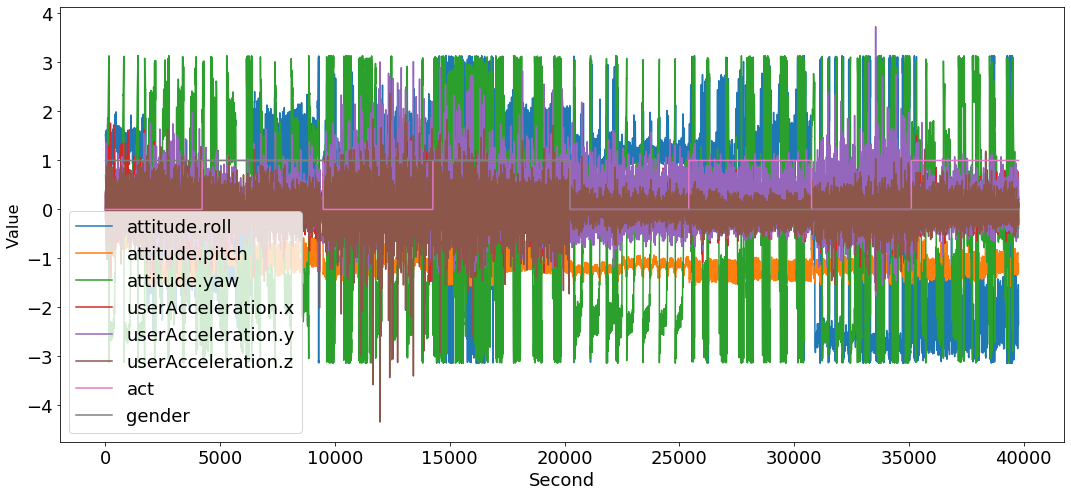

In [5]:
data = dataset.loc[(dataset['id'] < 3)|(dataset['id'] == 4)].loc[(dataset['trial'] > 0)&(dataset['trial'] < 5)]

data = data[['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z','act', 'gender']]
data.index = np.arange(len(data))

T = 50
K = 2
discrete = T//5
size_data = 39150

X_data = data.values[:size_data, :6]
List_of_x = np.arange(2*T, X_data.shape[0] - T) #ось времени

library.drow_data_multi(data)

# Извлечение признаков

Сингулярные числа (по 4 на ряд) разложения фазовой траектории:

In [6]:
N_comp = T

def get_spectrum_names(n):
    feature_names = []
    for ax in ['roll', 'pitch', 'yaw', 'x_acc', 'y_acc', 'z_acc']:
        for i in range(n):
            feature_names += [ax + '_' + 'specrum_' + str(i)]
    return feature_names

feature_names = get_spectrum_names(N_comp)

# phase track для каждой точки от T до len(phase_track) - (N, len, T)
phase_track = lib.return_phase_track(X_data, T) 

# basis vector - 2 компоненты сингулярного разложения в точках 2T,2T+discrete.. max-T-discrete - (len, 2*N)
List_of_basis_vector, List_of_basis_vector_s, List_of_basis_vector_c = lib.local_basis_multi(phase_track, T = T, 
                                                                      N_components = N_comp, discrete = discrete)

specrum_feats = pd.DataFrame(List_of_basis_vector_s,columns = feature_names)

specrum_feats

,roll_specrum_0,roll_specrum_1,roll_specrum_2,roll_specrum_3,roll_specrum_4,roll_specrum_5,roll_specrum_6,roll_specrum_7,roll_specrum_8,roll_specrum_9,...,z_acc_specrum_40,z_acc_specrum_41,z_acc_specrum_42,z_acc_specrum_43,z_acc_specrum_44,z_acc_specrum_45,z_acc_specrum_46,z_acc_specrum_47,z_acc_specrum_48,z_acc_specrum_49
0,7.536991,7.183248,3.028250,2.980463,1.245050,1.083378,0.959384,0.531102,0.497449,0.427274,...,0.354879,0.343481,0.334933,0.265857,0.253677,0.213862,0.179788,0.135427,0.104754,7.251529e-16
1,11.400271,11.089366,5.095827,3.910886,3.847797,2.281377,1.450809,1.363604,1.081720,0.687761,...,1.025264,0.991793,0.894382,0.889070,0.856965,0.847668,0.765555,0.757068,0.622562,6.191182e-01
2,11.584641,10.320471,6.429126,3.879523,3.858760,1.907859,1.465496,1.340111,0.938938,0.688081,...,1.016023,0.989763,0.962559,0.938408,0.880826,0.876907,0.792798,0.779283,0.643671,6.209998e-01
3,11.126887,10.195186,6.768973,4.285491,3.890349,2.060183,1.409191,1.226774,0.822758,0.655821,...,1.160400,1.090574,0.959337,0.945914,0.864876,0.857104,0.813637,0.803377,0.706158,6.723262e-01
4,10.605056,10.226431,6.286216,4.894995,4.248490,2.172869,1.258247,1.075230,0.717904,0.597276,...,1.105364,1.018384,0.989848,0.931668,0.924420,0.884593,0.808001,0.761000,0.644397,6.361988e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,21.215894,19.363435,3.411772,3.161109,1.752104,1.611185,0.898093,0.753571,0.748237,0.650525,...,0.625510,0.574264,0.553734,0.477778,0.470691,0.447243,0.410728,0.352637,0.328824,2.557839e-01
3896,22.199313,18.381109,3.363006,3.032202,1.873260,1.624140,0.909016,0.741238,0.725013,0.585252,...,0.576476,0.562491,0.487336,0.481819,0.473460,0.402109,0.386398,0.353944,0.308044,1.946273e-01
3897,23.464441,17.458905,3.204594,2.874497,1.963796,1.884246,0.956806,0.710328,0.641037,0.634221,...,0.467959,0.438832,0.415838,0.405117,0.392765,0.368973,0.350249,0.219344,0.194781,1.480051e-01
3898,21.469315,19.949396,3.110702,2.602064,1.987169,1.908184,1.018382,0.780384,0.724633,0.594823,...,0.414637,0.395534,0.375198,0.368597,0.319330,0.274904,0.219030,0.202679,0.164894,1.366887e-01


Параметры авторегрессии (по 50 на ряд):

In [7]:
n = T//2   # with free coef

def get_autoregressive_names(n):
    feature_names = []
    for ax in ['roll', 'pitch', 'yaw', 'x_acc', 'y_acc', 'z_acc']:
        for i in range(n):
            feature_names += [ax + '_' + 'autoreg_' + str(i)]
    return feature_names

feature_names = get_autoregressive_names(n)

def get_autoreg_feat_segm(ts, n):
    m = ts.shape[1]
    features = []
    for row in ts:
        X = np.zeros([m-n, n])
        Y = np.zeros(m-n)
        for i in range(m-n):
            X[i, :] = row[i:i+n]
            Y[i] = row[i+n]
        lr = LinearRegression()
        lr.fit(X, Y)
        features.append(lr.intercept_)
        features.extend(lr.coef_)  
    return features

def get_autoreg_features(X_data, n, discrete):
    if(n == 0): return np.asarray([])
    size = (X_data.shape[0]-3*T)//discrete
    params_autoreg = [None]*size
    for i in range(size):
        segm = lib.return_h(X_data, 2*T+i*discrete, 2*T)       
        params_autoreg[i] = get_autoreg_feat_segm(segm, n)   #n*N_row features
    return(np.asarray(params_autoreg))
    
params_autoreg = get_autoreg_features(X_data, n-1, discrete)
autoreg_feats = pd.DataFrame(params_autoreg,columns = feature_names)
autoreg_feats.to_csv("../data/features/autoreg_feats.csv", index=False)
autoreg_feats

,roll_autoreg_0,roll_autoreg_1,roll_autoreg_2,roll_autoreg_3,roll_autoreg_4,roll_autoreg_5,roll_autoreg_6,roll_autoreg_7,roll_autoreg_8,roll_autoreg_9,...,z_acc_autoreg_15,z_acc_autoreg_16,z_acc_autoreg_17,z_acc_autoreg_18,z_acc_autoreg_19,z_acc_autoreg_20,z_acc_autoreg_21,z_acc_autoreg_22,z_acc_autoreg_23,z_acc_autoreg_24
0,0.154208,-0.121930,0.099333,0.102621,-0.517402,1.007502,-1.122550,0.963620,-0.765680,0.475300,...,0.091609,-0.054391,-0.040685,-0.116262,0.088400,-0.253763,0.072996,-0.135446,-0.187703,0.877121
1,0.147338,-0.085365,0.053003,0.146127,-0.649707,1.192230,-1.270249,0.984236,-0.645852,0.385882,...,0.088330,-0.008442,-0.035250,-0.102562,0.076644,-0.217415,0.090865,-0.128982,-0.136577,0.850898
2,0.115848,-0.016480,0.007695,-0.115823,0.047414,0.197671,-0.197928,0.033580,0.041967,0.021610,...,0.157683,-0.013289,0.006176,-0.059411,0.071184,-0.188773,0.122632,-0.132207,-0.103288,0.939635
3,0.114347,0.072713,-0.196866,-0.064807,0.064465,0.274227,-0.119953,0.010235,-0.082784,-0.029753,...,0.102947,-0.050408,0.052827,-0.043447,0.094688,-0.248441,0.064344,-0.128186,-0.050388,0.930114
4,0.051920,0.106624,-0.202126,-0.090318,0.086749,0.289755,-0.154788,-0.002010,-0.033954,-0.021448,...,0.125859,0.064242,0.001436,-0.141011,0.095890,-0.193663,0.104880,-0.141074,-0.115191,0.948002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,-0.143663,-0.077546,0.155557,-0.069787,-0.129413,-0.073257,0.267509,0.050736,-0.356808,0.197144,...,-0.106341,0.055720,-0.134833,-0.001493,-0.110148,0.145748,-0.155705,0.376520,-0.225439,0.592625
3896,-0.133443,-0.052166,0.142587,-0.130359,-0.122374,0.081667,0.170690,-0.022736,-0.236362,0.052804,...,-0.100843,0.054930,-0.143288,0.011558,-0.096255,0.119458,-0.145236,0.384678,-0.246614,0.542679
3897,-0.140156,-0.072605,0.118461,-0.012236,-0.166372,-0.010814,0.250592,0.003497,-0.303372,0.046673,...,-0.088710,0.028839,-0.172561,-0.045392,-0.127416,0.098600,-0.146538,0.412923,-0.217415,0.598815
3898,-0.109587,-0.122683,0.249700,-0.082264,-0.255738,0.114370,0.271937,-0.139777,-0.250987,0.156928,...,-0.158497,0.122403,-0.327697,0.101392,-0.322684,0.301805,-0.379914,0.615987,-0.377889,0.677044


Коэффициенты Фурье разложения:

In [8]:
def get_fft_names(n):
    feature_names = []
    for ax in ['roll', 'pitch', 'yaw', 'x_acc', 'y_acc', 'z_acc']:
        for i in range(n):
            feature_names += [ax + '_' + 'fft_' + str(i)]
    return feature_names

feature_names = get_fft_names(2*T)

def get_fft_features_segm(ts, n):
    m = ts.shape[1]
    features = []
    
    for row in ts:
        h = sp.fftpack.rfft(row, n, axis=-1, overwrite_x=False)
        features.extend(h)
    
    return list(np.array(features)**2)

def get_fft_features(X_data, n, discrete):
    if(n == 0): return np.asarray([])
    size = (X_data.shape[0]-3*T)//discrete
    params_fft = [None]*size
    for i in range(size):
        segm = lib.return_h(X_data, 2*T+i*discrete, n)  
        params_fft[i] = get_fft_features_segm(segm, n)   #n*N_row features
    return(np.asarray(params_fft))
  
params_fft = get_fft_features(X_data, n = 2*T, discrete = discrete)
fft_feats = pd.DataFrame(params_fft,columns = feature_names)
fft_feats.to_csv("../data/features/fft_feats.csv", index=False)
fft_feats

,roll_fft_0,roll_fft_1,roll_fft_2,roll_fft_3,roll_fft_4,roll_fft_5,roll_fft_6,roll_fft_7,roll_fft_8,roll_fft_9,...,z_acc_fft_90,z_acc_fft_91,z_acc_fft_92,z_acc_fft_93,z_acc_fft_94,z_acc_fft_95,z_acc_fft_96,z_acc_fft_97,z_acc_fft_98,z_acc_fft_99
0,18866.268560,2.122149,3.310885,81.678866,106.273230,4.585390,10.798800,7.472270,1.361805,21.004341,...,0.008873,0.000073,2.461225,0.511450,0.770477,0.796658,0.375123,0.012852,1.622611,2.597686
1,18442.413797,0.512177,0.765175,71.927741,126.790125,1.238647,5.159756,7.235941,2.341931,13.497772,...,0.054697,0.846246,1.174710,1.112419,0.202969,0.624193,0.386527,0.264176,1.301424,3.190167
2,17782.518272,1.243224,1.638643,221.205709,40.116021,9.850671,3.015823,2.433564,23.004067,7.222349,...,0.092859,1.606543,0.145890,0.022180,1.018894,0.083184,1.202576,1.530649,0.271205,2.556875
3,17104.109388,6.890511,5.163327,0.615304,295.654784,0.637748,15.415112,0.035398,9.539325,3.143661,...,0.044460,2.522265,0.079543,0.354758,0.000142,2.646838,0.009556,0.555588,0.044256,4.778377
4,15957.184776,24.139712,24.024125,166.692915,77.261798,2.500752,2.048749,6.294702,34.154673,1.366637,...,0.013453,1.980691,0.656558,0.049196,0.832219,0.010036,1.689772,1.163919,0.584977,2.410989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,47870.192188,10.744497,31.503473,60.695109,741.748714,7.327387,39.528677,8.649952,8.531553,0.304207,...,0.005158,0.105741,0.878643,0.098516,0.013281,0.019784,0.182960,0.455795,0.000234,0.001314
3896,45886.903473,101.388701,0.568817,647.648853,18.211945,32.069821,20.357115,0.012663,0.217856,1.616986,...,0.241546,0.390085,0.005276,0.091280,0.002592,0.003199,0.065668,0.010527,0.079119,0.168615
3897,46563.064375,49.341668,25.951260,181.132213,544.099807,16.056395,55.724081,1.326933,0.238449,0.019626,...,0.254093,0.034814,0.079687,0.214779,0.101863,0.294385,0.005386,0.028637,0.066727,0.028921
3898,49943.606735,20.586798,35.592641,146.437509,583.507126,18.071404,46.035955,0.797093,34.119014,0.282655,...,0.272417,0.020069,0.310227,0.019791,0.040221,0.000020,0.025606,0.175444,0.010809,0.408361


In [19]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.data import iris_data
from sklearn.model_selection import GroupKFold

def selecting(X_feat,y, model):
    mask1 = [True if i % 600 < 400 else False for i in range(3900)]
    mask2 = [True if i % 600 > 399 else False for i in range(3900)]
    #X_train, y_train = X_feat[mask1], y[mask1]
    X_test, y_test = X_feat[mask2], y[mask2]
    X_train, y_train = X_feat, y

    X_train = sklearn.preprocessing.MinMaxScaler().fit_transform(X_train)
    X_test = sklearn.preprocessing.MinMaxScaler().fit_transform(X_test)

    select_feat = SelectPercentile(chi2, percentile=2.4)
    X_train = select_feat.fit_transform(X_train, y_train)

    best_feat = select_feat.get_support()
    bestmask = select_feat.get_support(indices=False)
    best = [[x,z] for x,y,z in zip(X_feat.columns, select_feat.get_support(), select_feat.scores_) if y == 1]
    best = pd.DataFrame(best) 
    
    X_test = select_feat.transform(X_test)
    plt.rcParams['figure.figsize'] = (18.0, 8.0)
    plt.bar([ str(i) for i in best[0]], best[1], color='g')
    
    groups = np.arange(len(y_train)) // 300
    cv_gen = GroupKFold(13).split(X_train, y_train, groups)
    cv = list(cv_gen)

    sfs = SFS(model, k_features=12, forward=False, floating=True, scoring='accuracy', 
          cv=cv, n_jobs=-1, verbose = 2)

    sfs.fit(X_train, y_train)
    print('best combination (ACC: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_idx_))

    X_train_sfs = sfs.transform(X_train)
    X_test_sfs = sfs.transform(X_test)
    
    best2 = np.asarray(best[0])
    mask = [i in sfs.k_feature_idx_ for i,x in enumerate(best[0])]
    best2 = best2[mask]
    
    df_train = pd.DataFrame(data=X_train_sfs, columns=best2)
    df_train.insert(2, "y", y_train, True)
    df_test = pd.DataFrame(data=X_test_sfs, columns=best2)
    df_test.insert(2, "y", y_test, True)
    
    return df_train, df_test

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
def Experiment(MODEL = LogisticRegression):
    result = np.zeros(9)
    
    # features Деятельность:
    X_feat = pd.concat([fft_feats, autoreg_feats, specrum_feats], axis=1)
    y = np.asarray([1 if x==1 else 0  for i,x in enumerate(data.values[2*T:size_data-T, 6]) if i % discrete == 0])

    df_train_act, df_test_act = selecting(X_feat,y, MODEL())
    df_train_act.to_csv("../data/df_train_act.csv", index=False)

    X_train_act, y_train_act = df_train_act.drop(['y'], axis=1), df_train_act[['y']]
    best_act = X_train_act.columns  
    
    # features Пол:
    X_feat = pd.concat([fft_feats, autoreg_feats, specrum_feats], axis=1)
    y = np.asarray([1 if x==1 else 0  for i,x in enumerate(data.values[2*T:size_data-T, 7]) if i % discrete == 0])

    df_train_gen, df_test_gen = selecting(X_feat,y, MODEL())
    df_train_gen.to_csv("../data/df_train_gen.csv", index=False)

    X_train_gen, y_train_gen = df_train_gen.drop(['y'], axis=1), df_train_gen[['y']]
    best_gen = X_train_gen.columns
    
    # Действия
    groups = np.arange(len(y_train_act)) // 300
    cv_act = GroupKFold(13).split(X_train_act, y_train_act, groups)
    cv = list(cv_act)

    clf = MODEL()
    scores = cross_val_score(clf, X_train_act, y_train_act, cv=cv)
    print("Accuracy cross validation: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
    result[0], result[1]=scores.mean(), scores.std() * 2

    # Пол
    groups = np.arange(len(y_train_gen)) // 300
    cv_gen = GroupKFold(13).split(X_train_gen, y_train_gen, groups)
    cv = list(cv_gen)

    clf = MODEL()
    scores = cross_val_score(clf, X_train_gen, y_train_gen, cv=cv)
    print("Accuracy cross validation: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
    result[2], result[3]=scores.mean(), scores.std() * 2
    
    # Активность на признаках + гендер
    clf = MODEL().fit(X_train_gen, y_train_gen)
    y_pred_gen = clf.predict(X_train_gen)
    X_train_act_g = X_train_act.assign(e=y_pred_gen)

    groups = np.arange(len(y_train_act)) // 300
    cv_gen = GroupKFold(13).split(X_train_act_g, y_train_act, groups)
    cv = list(cv_gen)

    clf = MODEL()
    scores = cross_val_score(clf, X_train_act_g, y_train_act, cv=cv)
    print("Accuracy cross validation: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
    result[4], result[5]=scores.mean(), scores.std() * 2

    # Гендер на признаках + активность
    clf = MODEL().fit(X_train_act, y_train_act)
    y_pred_act = clf.predict(X_train_act)
    X_train_gen_a = X_train_gen.assign(e=y_pred_act)

    groups = np.arange(len(y_train_gen)) // 300
    cv_gen = GroupKFold(13).split(X_train_gen_a, y_train_gen, groups)
    cv = list(cv_gen)

    clf = MODEL()
    scores = cross_val_score(clf, X_train_gen_a, y_train_gen, cv=cv)
    print("Accuracy cross validation: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
    result[6], result[7]=scores.mean(), scores.std() * 2
    
    result[8] = len(set(best_act) & set(best_gen))
     
    return result, X_train_act, df_train_gen

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:   17.3s finished

[2020-04-07 16:47:45] Features: 25/12 -- score: 0.8825641025641026[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   16.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished

[2020-04-07 16:48:03] Features: 24/12 -- score: 0.8825641025641026[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   14.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.8s finished

[2020-04-07 16:48:19] Features: 23/12 -- score: 0.8828205128205128[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurre

best combination (ACC: 0.888): (0, 1, 2, 3, 4, 5, 6, 7, 9, 14, 15, 18)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:   11.9s finished

[2020-04-07 16:51:18] Features: 25/12 -- score: 0.916923076923077[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   11.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished

[2020-04-07 16:51:31] Features: 24/12 -- score: 0.917948717948718[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   10.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.4s finished

[2020-04-07 16:51:42] Features: 23/12 -- score: 0.9199999999999999[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent

best combination (ACC: 0.928): (0, 7, 8, 9, 10, 11, 13, 14, 16, 17, 18, 20)

Accuracy cross validation: 0.888 (+/- 0.162)
Accuracy cross validation: 0.928 (+/- 0.212)
Accuracy cross validation: 0.882 (+/- 0.170)
Accuracy cross validation: 0.955 (+/- 0.112)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:  1.3min finished

[2020-04-07 16:55:07] Features: 25/12 -- score: 0.8935897435897435[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.0s finished

[2020-04-07 16:56:30] Features: 24/12 -- score: 0.9012820512820513[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.4s finished

[2020-04-07 16:57:46] Features: 23/12 -- score: 0.902051282051282[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurren

best combination (ACC: 0.911): (1, 2, 3, 4, 7, 8, 9, 15, 19, 20, 23, 24)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:   43.5s finished

[2020-04-07 17:15:22] Features: 25/12 -- score: 0.9482051282051281[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   41.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.1s finished

[2020-04-07 17:16:07] Features: 24/12 -- score: 0.9494871794871794[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   38.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.3s finished

[2020-04-07 17:16:49] Features: 23/12 -- score: 0.9525641025641025[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurre

best combination (ACC: 0.962): (0, 8, 9, 10, 14, 17, 18, 19, 21, 22, 23, 24)

Accuracy cross validation: 0.911 (+/- 0.143)
Accuracy cross validation: 0.962 (+/- 0.110)
Accuracy cross validation: 0.883 (+/- 0.191)
Accuracy cross validation: 0.960 (+/- 0.087)


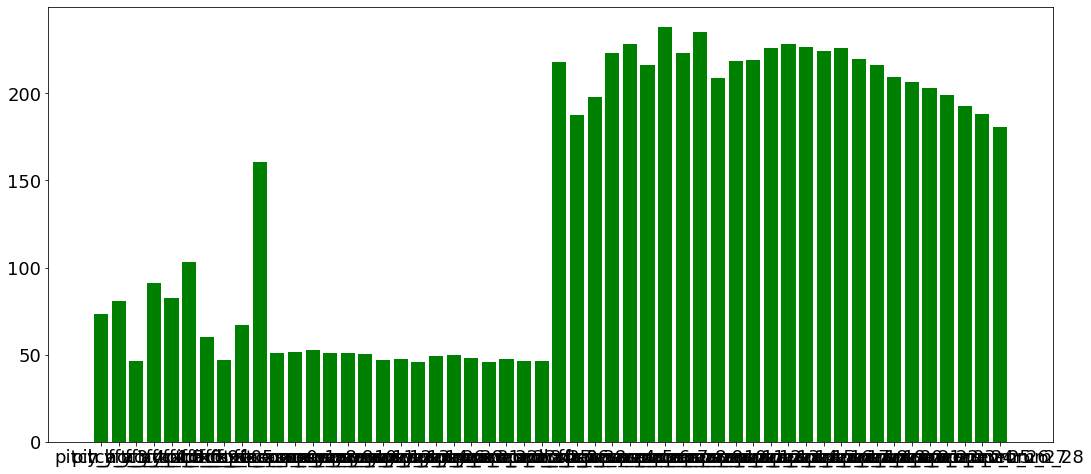

In [22]:
result = np.zeros((2,9))
result[0], X_train_act1, X_train_gen1 = Experiment(LogisticRegression)
result[1], X_train_act2, X_train_gen2 = Experiment(svm.SVC)

In [23]:
columns = ["act", "d act","gender","d gender", "act(+g)","d act(+g)","gen(+a)","d gen(+a)", "common",]
rows = ["LogRegression", "SVM"]
res = pd.DataFrame(data=result, index=rows, columns=columns)
res = np.round(res, 3)
res.to_csv("../data/result.csv", index=False)
res

,act,d act,gender,d gender,act(+g),d act(+g),gen(+a),d gen(+a),common
LogRegression,0.888,0.162,0.928,0.212,0.882,0.170,0.955,0.112,0.0
SVM,0.911,0.143,0.962,0.110,0.883,0.191,0.960,0.087,0.0


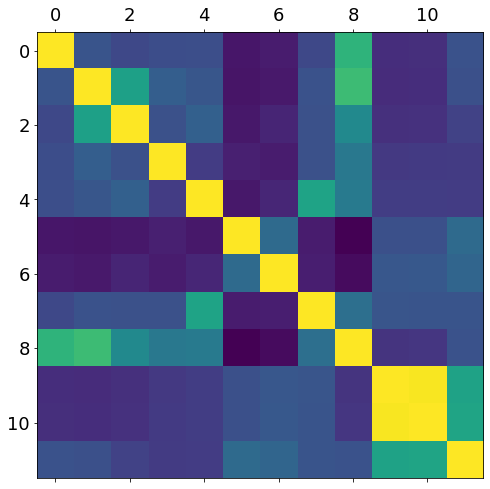

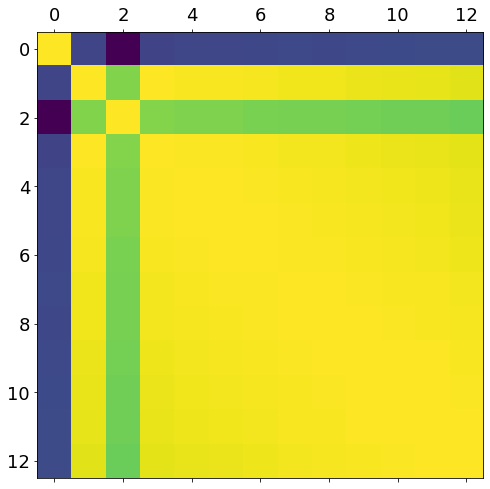

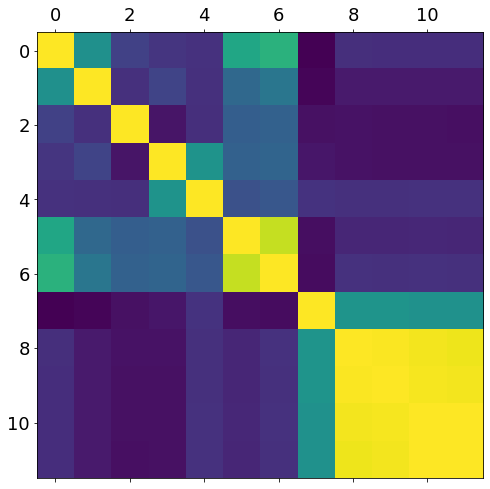

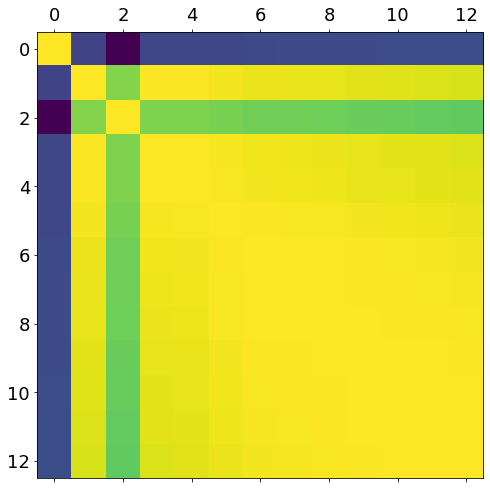

In [24]:
import matplotlib.pyplot as plt

plt.matshow(X_train_act1.corr())
plt.show()

plt.matshow(X_train_gen1.corr())
plt.show()

plt.matshow(X_train_act2.corr())
plt.show()

plt.matshow(X_train_gen2.corr())
plt.show()